# Notes

The sixth iteration of the modeling:
- prepare data split between series of HB sessions:
- - validation patients with multiple sessions
- - training patient with one sessions
- train classification
- train regression
- validate
        

In [2]:
import os 
import re
import csv
import json
import math
import random
import time

from itertools import chain
from datetime import datetime

In [3]:
import tensorflow as tf

# Allow memory growth for the GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"
        

2025-02-02 08:34:06.946590: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738481646.966176   25259 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738481646.972176   25259 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-02 08:34:06.992571: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2 Physical GPUs, 2 Logical GPUs


I0000 00:00:1738481649.971413   25259 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 266 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1
I0000 00:00:1738481649.972086   25259 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 5432 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:04:00.0, compute capability: 6.1


In [4]:
import pandas as pd
import numpy as np

from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import r2_score, mean_absolute_error, classification_report

import matplotlib.pyplot as plt
plt.style.use('_mpl-gallery')

Start time

In [5]:
TIME = {}

TIME['start'] = time.time()

# Constants

In [6]:
SEQ_MAX_LEN = 800
NUM_CLASSES = 6
NUM_EXERCISES = 9
NUM_FLAG_BS = 2

In [7]:
dir_root = os.path.join('..')
dir_data_root = os.path.join(dir_root, 'data')
dir_exercises = os.path.join(dir_data_root, 'json', 'patients')

# Data prep

In [8]:
patients = {}
for file_name in os.listdir(dir_exercises):
    if file_name == '.DS_Store': continue
    
    file_path = os.path.join(dir_exercises, file_name)
    ids = file_name.split('_')
    patient_id = ids[0]
    data = json.load(open(file_path, 'r'))
    if patient_id not in patients:
        patients[patient_id] = {
            'exercise_meta': [],
            'session_meta': {},
        }

    patients[patient_id]['exercise_meta'].append(data['meta'])
    patients[patient_id]['session_meta'][data['meta']['id_sessions']] = {
        'evaluation': data['meta']['evaluation'],
        'session_date': data['meta']['session_date'],
    }

In [9]:
testing = []
training = []
for patient_id, data in patients.items():
    num_sessions = len(data['session_meta'])
    if num_sessions >= 3:
        testing.append(patient_id)
    else:
        training.append(patient_id)
        
print(f'Number of patients with one session: {len(training)}, with three or more sessions {len(testing)}')
print(testing)

Number of patients with one session: 120, with three or more sessions 35
['107', '23', '35', '112', '86', '5', '111', '22', '136', '4', '34', '110', '117', '8', '77', '90', '44', '109', '24', '124', '63', '99', '58', '138', '3', '68', '28', '91', '55', '17', '79', '103', '132', '154', '40']


## Distribution of number of sessions

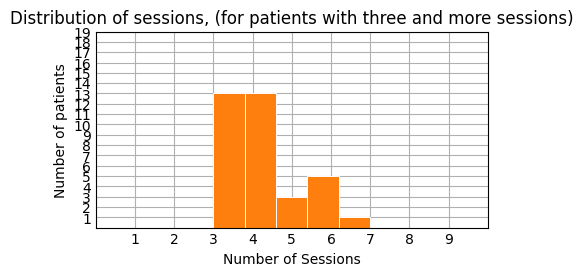

In [9]:
sessions_amounts = []
for patient_id in testing:
    sessions_meta = patients[patient_id]['session_meta']
    sessions_amounts.append(len(sessions_meta))

fig, ax = plt.subplots(figsize=(4,2)) 
#bars = ax.bar(x, sessions_amounts, color='tab:orange', edgecolor='white', linewidth=0.7)
ax.hist(sessions_amounts, color='tab:orange', edgecolor='white', linewidth=0.7, bins=5)

ax.set(
    xlim=(0, 10), 
    ylim=(0, 11),
    yticks=np.arange(1, 20),
    xticks=np.arange(1, 10),
    xlabel='Number of Sessions',
    ylabel='Number of patients',
    title=f'Distribution of sessions, (for patients with three and more sessions)'
)

plt.show() 

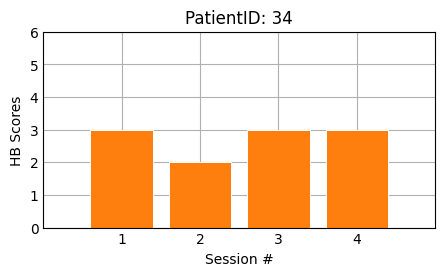

In [10]:
patient_id = '34'
patiens_sessions_data = patients[patient_id]['session_meta'].values()
exercises = [int(data['evaluation']) for data in sorted(patiens_sessions_data, key = lambda x: x['session_date'])]

fig, ax = plt.subplots(figsize=(4,2)) 
x = 1 + np.arange(len(exercises))
bars = ax.bar(x, exercises, color='tab:orange', edgecolor='white', linewidth=0.7)
    
ax.set(
    xlim=(0, len(exercises) + 1), 
    ylim=(0, 6),
    xticks=np.arange(1, len(exercises) + 1),
    xlabel='Session #',
    ylabel='HB Scores',
    title=f'PatientID: {patient_id}'
)

plt.show() 

## Build data set

In [11]:
TIME['data_processing_start'] = time.time()

In [12]:
from utils.input import setup, exercise_to_input

In [13]:
setup(os.path.join('..'), SEQ_MAX_LEN, NUM_EXERCISES, NUM_FLAG_BS)

print('complete')

complete


In [14]:
exercises_sources = [
    #dir_exercises_test
    dir_exercises,
    #dir_exercises_augmented
]

In [15]:
feature_engineering_setting = {
    'coordinates': True,
    'normalize_by_start': False,
    'normalize': False,
    'direction': True,
    'distance': True,
    'symetry_diference': False,
    're_base': True,
    'transformation_to_rebase': False,
    'extended_meta': True,
}

In [16]:
patient_input = {}
for exercise_source in exercises_sources:
    for file_name in os.listdir(exercise_source):
        file_path = os.path.join(exercise_source, file_name)

        if file_name == '.DS_Store': continue
        
        patient_id = file_name.split('_')[0]
        if patient_id not in patient_input:
            patient_input[patient_id] = []
            
        data = json.load(open(file_path, 'r'))
        
        _xs_meta, _xs_global, _xs_frontal, _xs_oral, _xs_orbital, _ys = exercise_to_input(file_path, feature_engineering_setting)
        patient_input[patient_id].append({
            'meta': data['meta'],
            'y': _ys,
            'x_meta': _xs_meta,
            'x_global': _xs_global,
            'x_frontal': _xs_frontal,
            'x_oral': _xs_oral,
            'x_orbital': _xs_orbital,
        })

Time preprocessing

In [17]:
TIME['data_processing_end'] = time.time()

# Modeling

In [18]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam

from sklearn.utils import class_weight

In [19]:
def get_dnn(inputLayer, region='default'):     
    m = Dense(4, activation="relu",name=f'{region}-Dense-1')(inputLayer)
    m = Model(inputs=inputLayer, outputs=m)

    return m

In [20]:
def get_cnn(inputLayer, region='default'):
    chanDim = -1    
    m = Conv1D(16, 3, padding='same', activation='relu', name=f'{region}-Convolution-1')(inputLayer)
    m = BatchNormalization(axis=chanDim, name=f'{region}-Normalization-1')(m)
    m = MaxPooling1D((2), name=f'{region}-Pooling-1')(m)
    m = Conv1D(32, 3, padding='same', activation='relu', name=f'{region}-Convolution-2')(m)
    m = BatchNormalization(axis=chanDim, name=f'{region}-Normalization-2')(m)
    m = MaxPooling1D((2), name=f'{region}-Pooling-2')(m)
    m = Conv1D(64, 3, padding='same', activation='relu', name=f'{region}-Convolution-3')(m)
    m = BatchNormalization(axis=chanDim, name=f'{region}-Normalization-3')(m)
    m = MaxPooling1D((2), name=f'{region}-Pooling-3')(m)
    m = Conv1D(64, 3, padding='same', activation='relu', name=f'{region}-Convolution-4')(m)
    m = BatchNormalization(axis=chanDim, name=f'{region}-Normalization-4')(m)
    m = MaxPooling1D((2), name=f'{region}-Pooling-4')(m)
    m = Flatten(name=f'{region}-Flatten-1')(m)
    m = Dropout(0.5, name=f'{region}-Dropout-1')(m)
    m = Dense(128, activation="relu", name=f'{region}-Dense-1')(m)
    m = Model(inputs=inputLayer, outputs=m)

    return m

In [21]:
def get_model_classification(meta_shape, global_shape, frontal_shape, oral_shape, orbital_shape):

    input_meta = Input(shape=meta_shape, name='Meta-Input')
    model_meta = get_dnn(input_meta, region='Meta')
    
    input_global = Input(shape=global_shape, name='Global-Input')
    model_global = get_cnn(input_global, region='Global')
    
    input_frontal = Input(shape=frontal_shape, name='Frontal-Input')
    model_frontal = get_cnn(input_frontal, region='Frontal')  

    input_oral = Input(shape=oral_shape, name='Oral-Input')
    model_oral = get_cnn(input_oral, region='Oral')  
    
    input_orbital = Input(shape=orbital_shape, name='Orbital-Input')
    model_orbital = get_cnn(input_orbital, region='Orbital')  
    
    
    model_contatenate = concatenate([
        model_meta.output, 
        model_global.output,
        model_frontal.output,
        model_oral.output,
        model_orbital.output,
    ])
    
    model_contatenate = Dense(32, activation="relu")(model_contatenate)
    model_contatenate = Dense(6, activation="softmax")(model_contatenate)
        
    model = Model(inputs=[
        model_meta.input,
        model_global.input,
        model_frontal.input,
        model_oral.input,
        model_orbital.input
    ], outputs=model_contatenate)

    initial_learning_rate = 0.001
    learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=initial_learning_rate,
        decay_steps=100000,
        decay_rate=0.96,
        staircase=True)

    model.compile(
        loss="sparse_categorical_crossentropy", 
        optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
        metrics=['accuracy']
    )
    
    
    return model

# One out evaluation

In [22]:
VERBOSE = 1
EPOCHS = 200
BATCH_SIZE = 16
MODEL = 'CLASSIFICATION' #'REGRESSION'
OUTPUT_DIR = os.path.join(dir_data_root, 'results', 'fs_evaluation', 'run_class_fs')


In [23]:
def error_size(ys, ys_pred):
    return [abs(y - y_p) for y, y_p in zip(ys, ys_pred)]

In [24]:
%matplotlib inline

{0: 0.36171827565270187, 1: 1.1855721393034826, 2: 1.1750493096646943, 3: 2.5958605664488017, 4: 2.7581018518518516, 5: 1.2608465608465609}
Epoch 1/200


I0000 00:00:1738425901.035540   44628 service.cc:148] XLA service 0x75f93c004680 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738425901.035561   44628 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
I0000 00:00:1738425901.035564   44628 service.cc:156]   StreamExecutor device (1): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2025-02-01 17:05:01.298691: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1738425902.557791   44628 cuda_dnn.cc:529] Loaded cuDNN version 90700
2025-02-01 17:05:04.930560: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.44GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more me

 10/120 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.1820 - loss: 3.3860

I0000 00:00:1738425911.140470   44628 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


116/120 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.1694 - loss: 2.7211

2025-02-01 17:05:14.779444: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.10GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-02-01 17:05:16.119232: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.31GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.1699 - loss: 2.7074

2025-02-01 17:05:21.933425: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'loop_add_reduce_subtract_fusion_2', 12 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_3', 8 bytes spill stores, 8 bytes spill loads



120/120 ━━━━━━━━━━━━━━━━━━━━ 33s 129ms/step - accuracy: 0.1700 - loss: 2.7040 - val_accuracy: 0.1300 - val_loss: 1.8322
Epoch 2/200
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.1947 - loss: 2.0285 - val_accuracy: 0.1174 - val_loss: 1.8120
Epoch 3/200
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.2295 - loss: 1.8928 - val_accuracy: 0.1027 - val_loss: 2.2412
Epoch 4/200
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.2058 - loss: 1.8269 - val_accuracy: 0.0503 - val_loss: 1.9188
Epoch 5/200
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.2544 - loss: 1.7528 - val_accuracy: 0.1887 - val_loss: 1.8253
Epoch 6/200
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.2185 - loss: 1.7514 - val_accuracy: 0.2201 - val_loss: 1.7107
Epoch 7/200
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.2654 - loss: 1.6824 - val_accuracy: 0.0419 - val_loss: 2.3588
Epoch 8/200
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.1770 - loss: 1.7755 - val_accura

2025-02-01 17:13:19.712914: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.00GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
/home/alan/.cache/pypoetry/virtualenvs/research-face-excercises-dynamics-ZQDiqUbo-py3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alan/.cache/pypoetry/virtualenvs/research-face-excercises-dynamics-ZQDiqUbo-py3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` paramete

[[1.25612901e-03 7.49036423e-12 1.85151727e-09 9.98743236e-01
  8.57052195e-14 7.26912845e-07]
 [5.83259881e-01 4.16736871e-01 3.26076247e-06 2.70124969e-15
  1.11351629e-10 6.27155083e-09]
 [8.08988154e-01 2.50452179e-02 1.64036468e-01 2.50870221e-06
  1.76673708e-03 1.60852273e-04]
 [9.34922835e-04 2.82681631e-05 9.98640597e-01 1.10771189e-15
  6.69596375e-06 3.89530964e-04]
 [1.06101637e-04 1.79097126e-10 7.88600175e-12 9.99879241e-01
  5.14798334e-14 1.46782559e-05]
 [5.19534111e-01 4.89132814e-02 4.30472374e-01 7.05319211e-15
  2.81357961e-06 1.07738026e-03]
 [9.97015595e-01 2.02703587e-09 2.20181118e-03 7.82504852e-04
  2.03473453e-11 7.03342522e-08]
 [3.31510633e-01 3.06618400e-02 6.34596288e-01 1.18216303e-06
  2.67012347e-03 5.59898152e-04]
 [9.99016881e-01 8.67624476e-04 9.82971396e-05 2.11052370e-10
  1.67671114e-05 4.50569189e-07]
 [9.97056842e-01 6.15466197e-05 4.03069425e-05 1.30474485e-08
  2.76205433e-03 7.93093423e-05]
 [9.98625636e-01 5.45959992e-05 4.94580454e-05 4.8

/tmp/ipykernel_44503/4236110680.py:233: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


 evaluation_metric: 0.3333333333333333
Done with evaluation for patient 34


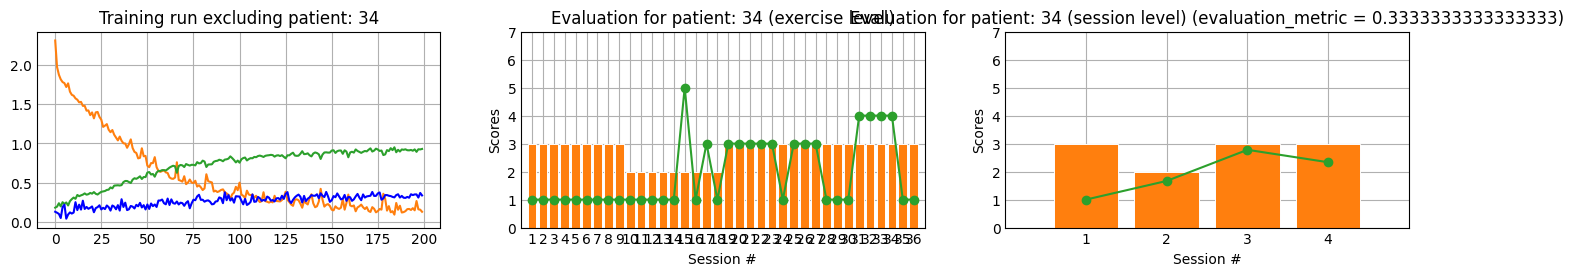

In [25]:
TIME['training_starts'] = time.time()

results = {}

TIME['training_start'] = time.time()

for test_parent_id in ['34']: #[]testing:
    xslist_meta = list()
    xslist_global = list()
    xslist_frontal = list()
    xslist_oral = list()
    xslist_orbital = list()
    yslist = list()

    xs_test_list_meta = list()
    xs_test_list_global = list()
    xs_test_list_frontal = list()
    xs_test_list_oral = list()
    xs_test_list_orbital = list()
    ys_test_list = list()
    test_meta_data = list()
    
    for parent_id in patient_input:
        if parent_id == test_parent_id:
            for exercise in patient_input[parent_id]:
                xs_test_list_meta.append(exercise['x_meta'])
                xs_test_list_global.append(exercise['x_global'])
                xs_test_list_frontal.append(exercise['x_frontal'])
                xs_test_list_oral.append(exercise['x_oral'])
                xs_test_list_orbital.append(exercise['x_orbital'])
                ys_test_list.append(exercise['y'])
                test_meta_data.append(exercise['meta'])
        else:
            for exercise in patient_input[parent_id]:
                xslist_meta.append(exercise['x_meta'])
                xslist_global.append(exercise['x_global'])
                xslist_frontal.append(exercise['x_frontal'])
                xslist_oral.append(exercise['x_oral'])
                xslist_orbital.append(exercise['x_orbital'])
                yslist.append(exercise['y']) 

        
    ys = np.array(yslist, dtype='int')
    xs_meta = np.array(xslist_meta, dtype='float32')   
    xs_global = np.array(xslist_global, dtype='float32') 
    xs_frontal = np.array(xslist_frontal, dtype='float32') 
    xs_oral = np.array(xslist_oral, dtype='float32') 
    xs_orbital = np.array(xslist_orbital, dtype='float32') 
    #print(ys.shape)
    #print(xs_meta.shape)
    #print(xs_global.shape)
    #print(xs_frontal.shape)
    #print(xs_oral.shape)
    #print(xs_orbital.shape)
    
    ys_test = np.array(ys_test_list, dtype='int')
    xs_test_meta = np.array(xs_test_list_meta, dtype='float32')   
    xs_test_global = np.array(xs_test_list_global, dtype='float32') 
    xs_test_frontal = np.array(xs_test_list_frontal, dtype='float32') 
    xs_test_oral = np.array(xs_test_list_oral, dtype='float32') 
    xs_test_orbital = np.array(xs_test_list_orbital, dtype='float32') 
    
    #print(ys_test.shape)
    #print(xs_test_meta.shape)
    #print(xs_test_global.shape)
    #print(xs_test_frontal.shape)
    #print(xs_test_oral.shape)
    #print(xs_test_orbital.shape)

    #print(test_meta_data)
    
    weight_training_classes = None
    if MODEL == 'CLASSIFICATION':
        class_weights = class_weight.compute_class_weight(class_weight='balanced',
            classes = np.unique(ys),
            y=ys)
        
        available_classes = np.unique(ys)
        weight_training_classes = {
            0: 0,
            1: 0,
            2: 0,
            3: 0,
            4: 0,
            5: 0,
        }
        
        for indx, value in enumerate(class_weights):
            weight_training_classes[available_classes[indx]] = value

    print(weight_training_classes)
    
    ###### REGRESSION
    model = None
    #if MODEL == 'REGRESSION':
    #    model = get_model_regression(xs_meta.shape[1:],xs_global.shape[1:],xs_frontal.shape[1:],xs_oral.shape[1:],xs_orbital.shape[1:])
    #if MODEL == 'CLASSIFICATION':
    #    model = get_model_classification(xs_meta.shape[1:],xs_global.shape[1:],xs_frontal.shape[1:],xs_oral.shape[1:],xs_orbital.shape[1:])
    
    model = get_model_classification(xs_meta.shape[1:],xs_global.shape[1:],xs_frontal.shape[1:],xs_oral.shape[1:],xs_orbital.shape[1:])    
    hist = model.fit(
        x=[
            xs_meta, 
            xs_global, 
            xs_frontal,
            xs_oral,
            xs_orbital
        ], 
        y=ys,
        validation_split=0.2,
        batch_size=BATCH_SIZE, 
        epochs=EPOCHS,
        class_weight=weight_training_classes,
        #shuffle=True,
        verbose=VERBOSE)
    
    # visualizing losses and accuracy
    fig, axs = plt.subplots(1,3,figsize=(14,2)) 
    
    if MODEL == 'CLASSIFICATION':
        acuracy_label = {
            'history_key': 'accuracy',
            'label': 'Accuracy'
        }
    if MODEL == 'REGRESSION':
        acuracy_label = {
            'history_key': 'mae',
            'label': 'Accuracy (MAE)'
        }
    train_loss = hist.history['loss']
    train_acc  = hist.history[acuracy_label['history_key']]
    val_acc = hist.history['val_accuracy']
    xc         = np.arange(len(train_loss))
    
    axs[0].set_title(f'Training run excluding patient: {test_parent_id}')
    axs[0].plot(xc, train_loss, color='tab:orange', label='Loss')
    axs[0].plot(xc, train_acc, color='tab:green', label=acuracy_label['label'])
    axs[0].plot(xc, val_acc, color='blue', label='Validation Accuracy')

    # evaluation
    y_output = model.predict([
        xs_test_meta,
        xs_test_global,
        xs_test_frontal,
        xs_test_oral,
        xs_test_orbital],verbose=0)
    y_pred = None
    evaluation_metric = None
    if MODEL == 'REGRESSION':
        y_pred = [x[0] for x in y_output]
        evaluation_metric = mean_absolute_error(ys_test, y_pred)   
    if MODEL == 'CLASSIFICATION':
        y_pred_softmax = model.predict([
            xs_test_meta,
            xs_test_global,
            xs_test_frontal,
            xs_test_oral,
            xs_test_orbital],verbose=0)
        y_pred = np.argmax(y_pred_softmax, axis=1)
        report = classification_report(ys_test, y_pred, output_dict=True)
        evaluation_metric = report['weighted avg']['f1-score']
        print(y_pred_softmax)
        print(y_pred)
        print(report)

        
    ## visualizing HB vs Prediction on excercise level
    result = [
        {
        'fs': y + 1, 
        'id': meta['id'], 
        'evaluation': int(meta['evaluation']), 
        'id_sessions': meta['id_sessions'],
        'session_date': meta['session_date']
        } 
        for y, meta in zip(y_pred, test_meta_data)
        ]
    result.sort(key = lambda x: (x['session_date'], x['id']))
    
    evaluations = [int(x['evaluation']) for x in result]
    fine_scores = [float(x['fs']) for x in result]
    xc = 1 + np.arange(len(evaluations))
    
    #print(f'size evaluations {len(evaluations)} evaluations: {evaluations}')
    #print(f'size fine_scores {len(fine_scores)} fine_scores: {fine_scores}')
    #print(f'size xc {len(xc)} fine_scores: {xc}')
    
    
    axs[1].bar(xc, evaluations, color='tab:orange', edgecolor='white', linewidth=0.7)
    axs[1].plot(xc, fine_scores, color='tab:green', linestyle='-', marker='o')   
    axs[1].set(
        xlim=(0, len(evaluations) + 1), 
        ylim=(0, 7),
        xticks=np.arange(1, len(evaluations) + 1),
        xlabel='Session #',
        ylabel='Scores',
        title=f'Evaluation for patient: {test_parent_id} (exercise level)'
    )
    
    aggregate_result = {}
    for exercise in result:
        if exercise['id_sessions'] not in aggregate_result:
            aggregate_result[exercise['id_sessions']] = {
                'evaluation': exercise['evaluation'],
                'session_date': exercise['session_date'],
                'fs': []
            }
        aggregate_result[exercise['id_sessions']]['fs'].append(exercise['fs'])
        
    aggregate_result_sorted = [
        {
            'evaluation': x['evaluation'], 
            'fs': sum(x['fs'])/len(x['fs'])
        } 
        for x in sorted(aggregate_result.values(), key = lambda x: x['session_date'])]        
                               
    evaluations_sessions = [int(x['evaluation']) for x in aggregate_result_sorted]
    fine_scores_sessions = [float(x['fs']) for x in aggregate_result_sorted]
    xc_sessions = 1 + np.arange(len(evaluations_sessions))

    axs[2].bar(xc_sessions, evaluations_sessions, color='tab:orange', edgecolor='white', linewidth=0.7)
    axs[2].plot(xc_sessions, fine_scores_sessions, color='tab:green', linestyle='-', marker='o')   
    axs[2].set(
        xlim=(0, len(evaluations_sessions) + 1), 
        ylim=(0, 7),
        xticks=np.arange(1, len(evaluations_sessions) + 1),
        xlabel='Session #',
        ylabel='Scores',
        title=f'Evaluation for patient: {test_parent_id} (session level) (evaluation_metric = {evaluation_metric})'
    )
    
    fig.savefig(os.path.join(OUTPUT_DIR, f'evaluation_patient{test_parent_id}_{int(time.time())}.svg'), format='svg', dpi=600) 
    fig.show() 
    
    print(f' evaluation_metric: {evaluation_metric}')
    print(f'Done with evaluation for patient {test_parent_id}')

    data_result = {
        'evaluations_sessions': evaluations_sessions,
        'fine_scores_sessions': fine_scores_sessions,
        'evaluations_exercises': evaluations,
        'fine_scores_exercises': fine_scores,
        'training_size': len(ys),
        'testing_size': len(ys_test),
        'evaluation_metric': evaluation_metric
    }
    json.dump(data_result, open(os.path.join(OUTPUT_DIR, f'evaluation_patient{test_parent_id}_{int(time.time())}.json') ,'w'))
    break
TIME['training_ends'] = time.time()  

End time

In [26]:
TIME['end'] = time.time()

In [27]:
print(f'Total processing took {TIME["end"] - TIME["start"]}')
print(f'Data processing took {TIME["data_processing_end"] - TIME["data_processing_start"]}')
print(f'Training took {TIME["training_ends"] - TIME["training_starts"]}')
print(f'Average training time {(TIME["training_ends"] - TIME["training_starts"])/len(testing)}')

Total processing took 1168.7077174186707
Data processing took 643.243255853653
Training took 512.8270909786224
Average training time 14.652202599389213
